# 3. Comparing Canonical Models

Authors: **Gorka Zamora-López** and **Matthieu Gilson**

---------------------

This notebook is part of an introductory tutorial for the use of *Stimulus-Response Network Analysis* ([SiReNetA](https://github.com/mb-BCA/SiReNetA)) to study the structure of complex networks:
1. *[Getting Started and Overview](1_GettingStarted.ipynb)*
2. *[Calculating Response to Stimulus and Metrics](2_Basics_StimRespMetrics.ipynb)*
3. **[Canonical Models](3_Basics_CanonModels.ipynb)**
4. *[Comparing Networks](4_UseCase_CompareNets.ipynb)*
5. *[Network Distance](5_UseCase_NetDist.ipynb)*
6. *[Weighted Networks](6_Basics_WeightedNets.ipynb)* 

---------------------

### Outline and functions used in this notebook
* Compare the responses for different propagation models with the same binary network.
* Introduce tools used in Fig 2 of [Zamora-López and Gilson (2024) Chaos](https://doi.org/10.1063/5.0202241)
* `Resp_DiscreteCascade` = `RespDC`
* `Resp_RandomWalk` = `RespRW`
* `Resp_ContCascade` = `RespCC`
* `Resp_LeakyCascade` = `RespLC`
* `Resp_ContDiffusion` = `RespCD`

---------------------

**TODO**: Use this NB to illustrate the origin of SRNA from graph metrics via the discrete cascade model.

#### Import libraries

To get started, the first thing we need is to load the libraries we will need to work.

In [1]:
# Python standard library imports
# Third party imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# import 
import sireneta as sna

In [2]:
# Define some plotting options to control visualization
%matplotlib inline
# Load the plotting options from a local file
from plot_specs import *

## 0. Mathematical description of the propagation models

In all that follows, $A$ is the connectivity matrix, which is undirected binary graph here although this can be relaxed (see Notebook 7).

### Discrete Cascade

$ R^t = A^t $

### Random Walk

$ R^t = L^t $ with the Laplacian $L = A - D$ with $D$ the diagonal matrix with the corresponding degrees of nodes in $A$.

### Continuous Cascade

$ R(t) = e^{A t} $ defined using the matrix exponential.

### Continuous Leaky Cascade

$ R(t) = e^{J t} - e^{J^0 t} $ with $J^0 = \frac{1}{\tau} I$ being a diagonal matrix and the Jacobian $J = J^0 + A$. The role of the leakage time-constant $\tau$ is to control the rate of leakage through the nodes, thus counter-balancing the tendency of the linear connectivity to cause the divergence of the system.

### Continuous Diffusion

$ R(t) = e^{L t} $ with the same Laplacian as above.

    

## 1. Comparison of network responses for the 5 propagation models above for an example network

We will
* load an example network
* compute the network response for the propagation models
* compare their temporal evolution, in terms of global response and node responses

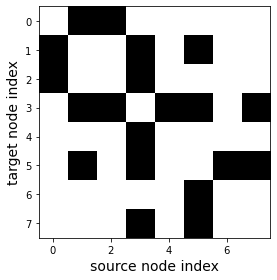

In [3]:
# Load a small network (binary or unweighted)
net = np.loadtxt('../Data/Testnet_N8.txt', dtype=int)
N = len(net)

plt.figure(figsize=[4,4])
plt.imshow(net, cmap='gray_r')
plt.xlabel('source node index')
plt.ylabel('target node index')
plt.tight_layout()

In [4]:
# normalize connectivity with respect to largest eigenvalue
lambda_max = np.real(np.linalg.eigvals(net)).max()
net_norm = net / lambda_max

# Time stamps: td for discrete time and tc for continuous time
dt = 0.1
T = 20.1
td = np.arange(0,T, dtype=int)
nT = td.size
tc = np.arange(0,T,dt)

# Responses for the 5 propagation models
rdc = sna.Resp_DiscreteCascade(net, tmax=20)
rrw = sna.Resp_RandomWalk(net, tmax=20)
rcc = sna.Resp_ContCascade(net, tmax=20, timestep=dt)
rlc = sna.Resp_LeakyCascade(net_norm, tau=0.8, tmax=20, timestep=dt)
rcd = sna.Resp_ContDiffusion(net, tmax=20, timestep=dt, case='full')

# list of responses and time stamps
ts = [td, td, tc, tc, tc]
rs = [rdc, rrw, rcc, rlc, rcd]
labels = ['dc', 'rw', 'cc', 'lc', 'cd']
n_pm = 5

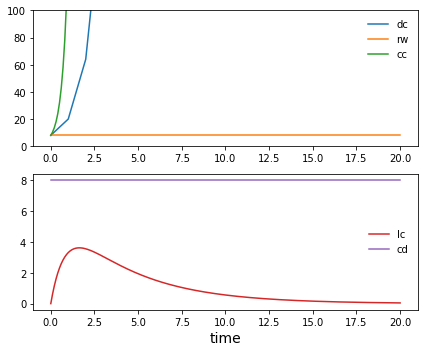

In [5]:
# plots of global responses

plt.figure(figsize=[6,5])
plt.subplot(211)
for i in range(0,3):
    plt.plot(ts[i], sna.GlobalResponse(rs[i]), color=std_cols[i], label=labels[i])
plt.axis(ymin=0, ymax=100)
plt.legend(fontsize=10)
plt.subplot(212)
for i in range(3,5):
    plt.plot(ts[i], sna.GlobalResponse(rs[i]), color=std_cols[i], label=labels[i])
plt.xlabel('time')
plt.legend(fontsize=10)
plt.tight_layout()

The above plots show vert distinct evolutions for the different models:
* the discrete and continuous cascades appear similar with an explosion of activity
* the random walk and continuous diffusion have constant activity, as expected from conservative dynamic systems
* the leaky cascade has a transient response that eventually fades away

Below, we replot the discrete and continuous cascades with a log y-axis to show their exponential increase.

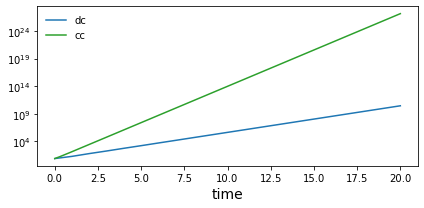

In [6]:
plt.figure(figsize=[6,3])
for i in [0,2]:
    plt.semilogy(ts[i], sna.GlobalResponse(rs[i]), color=std_cols[i], label=labels[i])
plt.legend(fontsize=10)
plt.xlabel('time')
plt.tight_layout()

Let's now have a look at the node responses, to see how the propagation models capture the network structure.

In [7]:
# calculate the node responses
inrs = []
onrs = []
for i in range(n_pm):
    inrs.append(sna.NodeResponses(rs[i])[0])
    onrs.append(sna.NodeResponses(rs[i])[1])

aspects = [0.5, 0.5, 5.0, 5.0, 5.0]

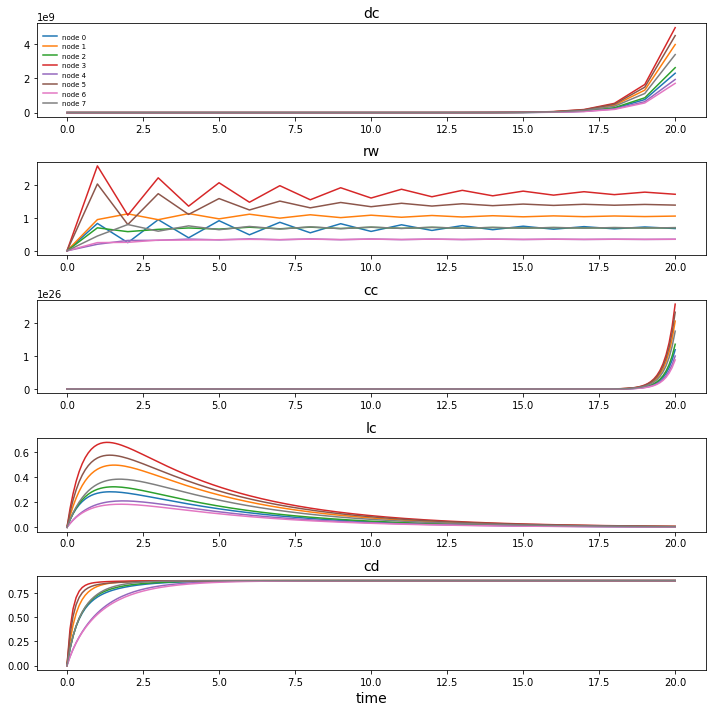

In [8]:
# plot the node responses as curves

plt.figure(figsize=[10,10])
for i in range(n_pm):
    plt.subplot(n_pm,1,i+1)
    for j in range(N):
        plt.plot(ts[i], inrs[i][:,j], label=f'node {j}')
    plt.title(labels[i])
    if i==0:
        plt.legend(loc='center left', fontsize=7)
plt.xlabel('time')
plt.tight_layout()

We observe the same ranking in terms of node activity for the three cascades, despite their distinct evolutions: the red, brown and orange nodes have the largest activities, while the purple and magenta nodes have the lowest activities.

The random walk also provides a similar picture for large times: the saturating values of the node activity also match the ranking of the cascades.

However, for the continuous diffusion, the time to saturation provides the corresponding ranking for the nodes.

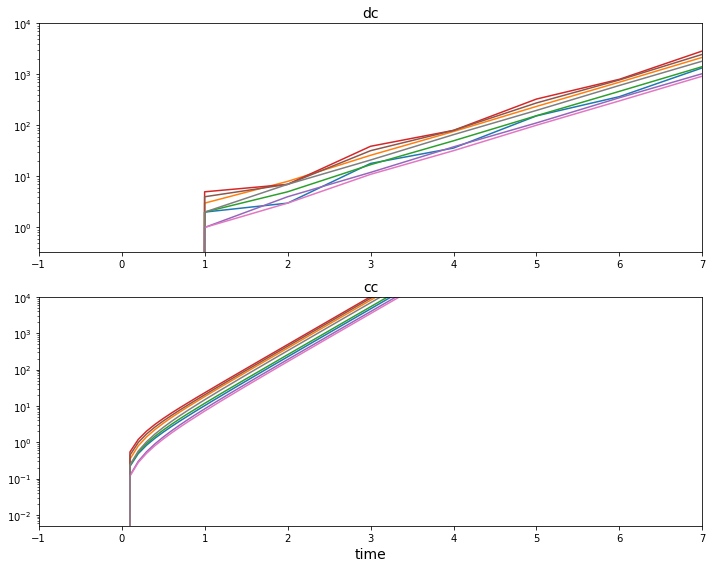

In [9]:
# plot the node responses for the discrete and continuous cascades with log y-axis

plt.figure(figsize=[10,8])
for ii, i in enumerate([0,2]):
    plt.subplot(2,1,ii+1)
    plt.semilogy(ts[i], inrs[i])
    plt.title(labels[i])
    plt.axis(xmax=7, ymax=1e4)
plt.xlabel('time')
plt.tight_layout()

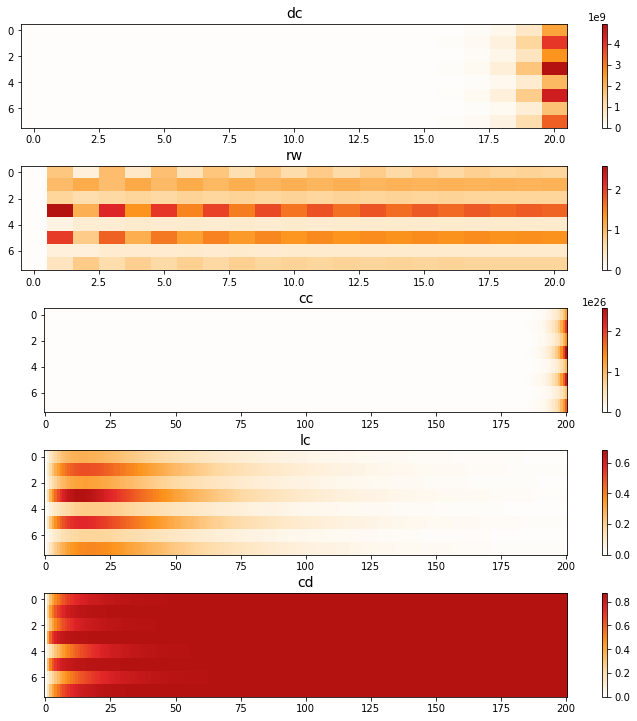

In [11]:
# plot the node responses as temporal raster (or carpet) plots

plt.figure(figsize=[10,10])
for i in range(n_pm):
    plt.subplot(n_pm,1,i+1)
    plt.imshow(inrs[i].T, aspect=aspects[i], interpolation='nearest', cmap=new_Reds)
    plt.title(labels[i])
    plt.colorbar()
plt.tight_layout()

## 2. Comparison of responses at the connection level

Going further, we can compare the interactions for each connection between two models. Note that we may have to match the discrete and continuous times.

Some models provide the same information at the connection level (as before for the node level) for large times, even though they may differ at early times.

*Try different times below as suggested for the considered models, then change the propagation models*.

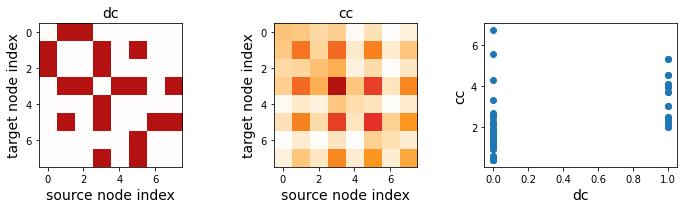

In [12]:
# index i for propagation model: 0 = discrete cascade, 1 = random walk, 2 = continuous cascade, 3 = leaky cascade, 4 = continuous diffusion

# dicrete cascade
i1 = 0
t1 = 1 # try 2, 4, 6, 8, 10

# continuous cascade
i2 = 2
t2 = int(t1/dt)

# matrix and scatter plot 
plt.figure(figsize=[10,3])

plt.subplot(1,3,1)
plt.imshow(rs[i1][t1,:,:], cmap=new_Reds)
plt.xlabel('source node index')
plt.ylabel('target node index')
plt.title(labels[i1])

plt.subplot(1,3,2)
plt.imshow(rs[i2][t2,:,:], cmap=new_Reds)
plt.xlabel('source node index')
plt.ylabel('target node index')
plt.title(labels[i2])

plt.subplot(1,3,3)
plt.scatter(rs[i1][t1,:,:], rs[i2][t2,:,:])
plt.xlabel(labels[i1])
plt.ylabel(labels[i2])

plt.tight_layout()

## 3. TODO APPENDIX OF PAPER

Comparison between continuous and discrete random walk